In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu
from matplotlib import pyplot as plt
import seaborn as sns
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
from itertools import islice

In [2]:
base_dir = "/mnt/Monolith/ML/kaggle/input/fake-or-real-the-impostor-hunt/data/train"
rows = []

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".txt"):
            file_path = os.path.join(root, file)
            with open(file_path, "r", encoding="utf-8") as f:
                content = f.read()
            rows.append({
                "article": os.path.basename(root),  # e.g., article_0000
                "filename": file,                   # e.g., file_1.txt
                "text": content                     # file contents
            })

train_df = pd.DataFrame(rows)
print(train_df.head())

        article    filename                                               text
0  article_0094  file_1.txt  The new detector system was first tested on 30...
1  article_0094  file_2.txt  The new detector system was first tested on 30...
2  article_0051  file_1.txt  From the glittering expanse of the cosmos, tal...
3  article_0051  file_2.txt  The only modification made to the system was a...
4  article_0086  file_1.txt  The formation and presence of stars in the cen...


In [3]:
base_dir = "/mnt/Monolith/ML/kaggle/input/fake-or-real-the-impostor-hunt/data/test"
rows = []

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".txt"):
            file_path = os.path.join(root, file)
            with open(file_path, "r", encoding="utf-8") as f:
                content = f.read()
            rows.append({
                "article": os.path.basename(root),  # e.g., article_0000
                "filename": file,                   # e.g., file_1.txt
                "text": content                     # file contents
            })

test_df = pd.DataFrame(rows)
print(test_df.head())

        article    filename                                               text
0  article_1008  file_1.txt  In the central star cluster, images taken in t...
1  article_1008  file_2.txt  In the central study area of the Galactic Cent...
2  article_0094  file_1.txt  The TIMER project's large data set enables sci...
3  article_0094  file_2.txt  The TIMER project's large data set enables sci...
4  article_0526  file_1.txt  The GRAVITY instrument requires star separator...


In [4]:
target_df = pd.read_csv("/mnt/Monolith/ML/kaggle/input/fake-or-real-the-impostor-hunt/data/train.csv")
target_df.head()

,id,real_text_id
0,0,1
1,1,2
2,2,1
3,3,2
4,4,2


In [5]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   id            95 non-null     int64
 1   real_text_id  95 non-null     int64
dtypes: int64(2)
memory usage: 1.6 KB


In [6]:
target_df.describe()

,id,real_text_id
count,95.000000,95.000000
mean,47.000000,1.515789
std,27.568098,0.502402
min,0.000000,1.000000
25%,23.500000,1.000000
50%,47.000000,2.000000
75%,70.500000,2.000000
max,94.000000,2.000000


In [7]:
train_df.sort_values(by=['article'], inplace = True)
train_df.reset_index(drop=True, inplace=True)
train_df.head()

,article,filename,text
0,article_0000,file_2.txt,The China relay network has released a signifi...
1,article_0000,file_1.txt,The VIRSA (Visible Infrared Survey Telescope A...
2,article_0001,file_1.txt,China\nThe goal of this project involves achie...
3,article_0001,file_2.txt,The project aims to achieve an accuracy level ...
4,article_0002,file_1.txt,Scientists can learn about how galaxies form a...


In [8]:
nltk.download("punkt")
nltk.download("stopwords")


[nltk_data] Downloading package punkt to /home/moogedelic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/moogedelic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words("english"))

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 95.8 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [10]:
# --- Comprehensive AI phrase detection ---
ai_phrases = [
    # Overly formal/clinical language patterns
    "it is important to note", "it should be noted that", "it is worth noting",
    "it is essential to", "it is crucial to", "it is vital to", "it is necessary to",
    "one must consider", "one should bear in mind", "it bears mentioning",
    "it is imperative", "it cannot be overstated", "it goes without saying",
    "it is incumbent upon", "it behooves one to", "it is advisable to",
    "it would be remiss not to", "it is prudent to", "it is judicious to",
    "it stands to reason", "it follows that", "it logically follows",
    "it is evident that", "it is clear that", "it is obvious that",
    "it is apparent that", "it is manifest that", "it is undeniable that",
    
    # Balanced/objective framing (AI tries to be neutral)
    "on one hand", "on the other hand", "while it is true that", "although",
    "it is important to balance", "both sides of", "various perspectives",
    "multiple viewpoints", "different approaches", "range of opinions",
    "spectrum of views", "nuanced understanding", "complex issue",
    "multifaceted problem", "various factors", "multiple considerations",
    "competing interests", "divergent views", "contrasting opinions",
    "conflicting perspectives", "opposing viewpoints", "alternative interpretations",
    "different schools of thought", "varied approaches", "diverse methodologies",
    "multiple dimensions", "various aspects", "different facets",
    "competing theories", "alternative explanations", "various interpretations",
    "different angles", "multiple lenses", "various frameworks",
    
    # Hedging and uncertainty (AI being cautious)
    "it appears that", "it seems that", "it would appear", "it is likely that",
    "it is possible that", "it may be that", "it could be argued",
    "some might argue", "one could suggest", "it is conceivable",
    "potentially", "arguably", "presumably", "ostensibly", "seemingly",
    "it is plausible that", "it is reasonable to assume", "it is fair to say",
    "it might be suggested", "it could be contended", "it is debatable whether",
    "it remains to be seen", "it is uncertain whether", "it is unclear if",
    "the jury is still out", "time will tell", "only time will tell",
    "it is too early to tell", "the verdict is still out", "it is hard to say",
    "it is difficult to determine", "it is challenging to assess", "it is tough to gauge",
    
    # Academic/formal conjunctions and transitions
    "furthermore", "moreover", "additionally", "consequently", "therefore",
    "thus", "hence", "accordingly", "nevertheless", "nonetheless",
    "however", "conversely", "in contrast", "alternatively", "subsequently",
    "notwithstanding", "albeit", "whereas", "whilst", "indeed",
    "in fact", "as a matter of fact", "in reality", "in practice",
    "in theory", "theoretically", "practically speaking", "realistically",
    "objectively speaking", "subjectively", "relatively speaking", "comparatively",
    "proportionally", "correspondingly", "similarly", "likewise",
    "by the same token", "in the same vein", "along the same lines",
    
    # Comprehensive/exhaustive language
    "comprehensive analysis", "thorough examination", "detailed study",
    "extensive research", "in-depth investigation", "careful consideration",
    "systematic approach", "methodical analysis", "rigorous evaluation",
    "exhaustive review", "meticulous examination", "scrupulous analysis",
    "painstaking research", "intensive study", "comprehensive overview",
    "thorough assessment", "detailed evaluation", "extensive investigation",
    "in-depth analysis", "comprehensive examination", "systematic review",
    "methodical evaluation", "rigorous assessment", "careful analysis",
    "thorough investigation", "detailed assessment", "comprehensive study",
    
    # Generic/vague intensifiers
    "particularly", "especially", "notably", "significantly", "considerably",
    "substantially", "remarkably", "exceptionally", "extraordinarily",
    "tremendously", "immensely", "vastly", "greatly", "highly",
    "extremely", "exceedingly", "supremely", "utterly", "thoroughly",
    "completely", "entirely", "totally", "absolutely", "perfectly",
    "quite", "rather", "fairly", "reasonably", "moderately",
    "somewhat", "slightly", "marginally", "incrementally", "progressively",
    "increasingly", "steadily", "consistently", "persistently", "continuously",
    
    # Qualification phrases (AI hedging)
    "to some extent", "to a certain degree", "in many ways", "in some respects",
    "for the most part", "by and large", "generally speaking", "broadly speaking",
    "in most cases", "under normal circumstances", "typically", "ordinarily",
    "more often than not", "as a general rule", "in the majority of cases",
    "under typical conditions", "in standard situations", "conventionally",
    "traditionally", "historically", "customarily", "habitually",
    "routinely", "regularly", "commonly", "frequently", "often",
    "occasionally", "sometimes", "periodically", "intermittently", "sporadically",
    
    # Abstract/conceptual language
    "fundamental principles", "underlying concepts", "basic tenets", 
    "core elements", "essential components", "key factors", "primary aspects",
    "main characteristics", "principal features", "central themes",
    "foundational elements", "basic building blocks", "elementary components",
    "primary constituents", "essential ingredients", "vital components",
    "crucial elements", "critical factors", "important aspects",
    "significant features", "notable characteristics", "distinguishing traits",
    "defining qualities", "inherent properties", "intrinsic attributes",
    "fundamental qualities", "basic attributes", "essential properties",
    
    # Process/methodology language
    "step-by-step approach", "systematic process", "methodical procedure",
    "structured framework", "organized manner", "logical sequence",
    "coherent structure", "well-defined process", "clear methodology",
    "systematic methodology", "organized approach", "structured process",
    "methodical framework", "logical progression", "sequential approach",
    "orderly process", "systematic procedure", "organized methodology",
    "structured approach", "coherent framework", "logical structure",
    "methodical progression", "systematic sequence", "organized procedure",
    "structured methodology", "logical framework", "coherent approach",
    
    # Emphasis on importance/significance
    "of paramount importance", "of utmost significance", "critically important",
    "absolutely essential", "fundamentally important", "vitally important",
    "of great significance", "particularly relevant", "highly significant",
    "extremely important", "exceptionally significant", "remarkably important",
    "notably significant", "especially relevant", "particularly pertinent",
    "highly relevant", "extremely pertinent", "exceptionally relevant",
    "critically relevant", "vitally relevant", "fundamentally relevant",
    "essentially important", "basically significant", "primarily important",
    "chiefly significant", "mainly important", "largely significant",
    
    # Generic positive/negative assessments
    "positive impact", "negative consequences", "beneficial effects",
    "adverse outcomes", "favorable results", "unfavorable circumstances",
    "advantageous position", "disadvantageous situation", "optimal solution",
    "suboptimal outcome", "desirable result", "undesirable consequence",
    "constructive approach", "destructive tendency", "productive method",
    "counterproductive strategy", "effective technique", "ineffective approach",
    "successful implementation", "unsuccessful attempt", "fruitful endeavor",
    "fruitless effort", "meaningful contribution", "meaningless gesture",
    "valuable insight", "worthless observation", "useful information",
    "useless data", "relevant detail", "irrelevant point",
    
    # Conclusion/summary phrases
    "in conclusion", "to summarize", "in summary", "overall", "all things considered",
    "taking everything into account", "when all is said and done", "ultimately",
    "in the final analysis", "the bottom line", "to sum up", "in essence",
    "at the end of the day", "in the last analysis", "to conclude",
    "to wrap up", "in closing", "to finish", "finally", "lastly",
    "in brief", "in short", "briefly", "succinctly", "concisely",
    "to put it simply", "simply put", "in simple terms", "basically",
    "essentially", "fundamentally", "primarily", "chiefly", "mainly",
    "largely", "mostly", "generally", "typically", "usually",
    
    # Formulaic sentence starters
    "there are several reasons why", "there are many factors that",
    "there are numerous benefits to", "there are various approaches to",
    "there are different ways to", "there are multiple strategies for",
    "it is widely recognized that", "it is commonly understood that",
    "it is generally accepted that", "it is universally acknowledged that",
    "experts agree that", "research shows that", "studies indicate that",
    "evidence suggests that", "data reveals that", "findings demonstrate that",
    "analysis shows that", "investigation reveals that", "examination indicates that",
    "assessment suggests that", "evaluation demonstrates that", "review shows that",
    
    # Redundant emphasis patterns
    "each and every", "first and foremost", "last but not least",
    "one and only", "null and void", "fair and square",
    "safe and sound", "tried and true", "pure and simple",
    "cut and dried", "rough and ready", "free and clear",
    "peace and quiet", "hustle and bustle", "trials and tribulations",
    "hopes and dreams", "trials and errors", "ups and downs",
    "ins and outs", "pros and cons", "dos and don'ts",
    "rights and responsibilities", "rules and regulations", "terms and conditions",
    
    # Overuse of superlatives
    "most important", "most significant", "most relevant", "most appropriate",
    "most effective", "most efficient", "most successful", "most beneficial",
    "most valuable", "most useful", "most practical", "most logical",
    "best practice", "best approach", "best method", "best strategy",
    "optimal solution", "ideal situation", "perfect example", "classic case",
    "prime example", "perfect illustration", "textbook example", "model case",
    "sterling example", "quintessential instance", "archetypal case", "paradigmatic example"
]

In [11]:
# --- Comprehensive transition words ---
transition_words = [
    # Addition and continuation
    "however", "therefore", "moreover", "thus", "furthermore", "additionally", 
    "also", "besides", "in addition", "what's more", "equally important", 
    "likewise", "similarly", "correspondingly", "in the same way", "along with",
    "together with", "coupled with", "not to mention", "to say nothing of",
    "let alone", "much less", "as well as", "including", "plus", "and",
    "both", "either", "neither", "not only", "but also", "indeed", "in fact",
    "actually", "as a matter of fact", "in reality", "certainly", "surely",
    "of course", "naturally", "obviously", "clearly", "undoubtedly",
    
    # Contrast and opposition
    "nevertheless", "nonetheless", "on the other hand", "in contrast", 
    "conversely", "alternatively", "instead", "rather", "yet", "still", 
    "although", "though", "whereas", "while", "despite", "in spite of", 
    "but", "on the contrary", "even so", "even though", "regardless", 
    "notwithstanding", "all the same", "at the same time", "be that as it may",
    "having said that", "that said", "in any case", "in any event", "anyway",
    "anyhow", "at any rate", "after all", "above all", "in contrast to",
    "unlike", "contrary to", "opposite to", "as opposed to", "rather than",
    "instead of", "in place of", "in lieu of",
    
    # Cause, effect, and consequence
    "consequently", "as a result", "accordingly", "hence", "for this reason", 
    "because of this", "due to", "owing to", "since", "because", "so", "then",
    "therefore", "thus", "as a consequence", "in consequence", "as a result of",
    "resulting from", "stemming from", "arising from", "brought about by",
    "caused by", "leading to", "giving rise to", "resulting in", "producing",
    "creating", "generating", "bringing about", "causing", "so that", "in order to",
    "for the purpose of", "with the aim of", "with the intention of",
    
    # Time and sequence
    "first", "second", "third", "initially", "subsequently", "next", "after", 
    "before", "meanwhile", "simultaneously", "finally", "lastly", "in conclusion", 
    "eventually", "previously", "afterwards", "later", "earlier", "formerly",
    "at first", "in the beginning", "to begin with", "to start with", "at the outset",
    "at the same time", "concurrently", "in the meantime", "in the interim",
    "during", "while", "as", "when", "whenever", "once", "as soon as",
    "immediately", "instantly", "shortly", "soon", "presently", "currently",
    "now", "nowadays", "these days", "recently", "lately", "ultimately",
    "in the end", "at last", "at length", "in due course", "in time",
    
    # Examples and illustration
    "for example", "for instance", "such as", "namely", "specifically", 
    "in particular", "to illustrate", "as an illustration", "case in point", 
    "as evidence", "to demonstrate", "to show", "to prove", "as proof",
    "witness", "consider", "take", "suppose", "imagine", "assume",
    "let us say", "say", "that is", "that is to say", "in other words",
    "to put it another way", "to rephrase", "to clarify", "to explain",
    
    # Summary and conclusion
    "in summary", "to summarize", "to conclude", "overall", "all in all", 
    "in general", "on the whole", "to sum up", "in short", "briefly",
    "in brief", "in essence", "essentially", "basically", "fundamentally",
    "primarily", "chiefly", "mainly", "mostly", "largely", "generally speaking",
    "broadly speaking", "all things considered", "taking everything into account",
    "in the final analysis", "when all is said and done", "at the end of the day",
    "the bottom line is", "in closing", "to wrap up", "to conclude",
    
    # Emphasis and intensification
    "indeed", "certainly", "definitely", "absolutely", "positively", "without doubt",
    "beyond doubt", "unquestionably", "undeniably", "indubitably", "surely",
    "assuredly", "decidedly", "clearly", "obviously", "evidently", "plainly",
    "manifestly", "patently", "unmistakably", "particularly", "especially",
    "notably", "remarkably", "significantly", "importantly", "crucially",
    "vitally", "essentially", "primarily", "above all", "most importantly"
]


In [12]:
# --- Comprehensive hedge words ---
hedge_words = [
    # Probability and possibility
    "maybe", "perhaps", "possibly", "probably", "likely", "unlikely", "might", 
    "may", "could", "would", "should", "potentially", "conceivably", "presumably", 
    "supposedly", "allegedly", "reportedly", "apparently", "seemingly", "ostensibly", 
    "evidently", "arguably", "tentatively", "provisionally", "conceivably",
    "theoretically", "hypothetically", "potentially", "plausibly", "feasibly",
    "presumably", "supposedly", "purportedly", "reputedly", "rumored",
    "claimed", "alleged", "reported", "suggested", "implied", "inferred",
    
    # Degree and extent modifiers
    "somewhat", "rather", "quite", "fairly", "relatively", "comparatively", 
    "essentially", "basically", "generally", "typically", "usually", "often", 
    "frequently", "occasionally", "sometimes", "rarely", "seldom", "hardly", 
    "barely", "almost", "nearly", "approximately", "roughly", "about",
    "around", "close to", "near", "nearly", "practically", "virtually",
    "more or less", "sort of", "kind of", "type of", "something of",
    "a bit", "a little", "slightly", "moderately", "considerably", "substantially",
    "significantly", "markedly", "noticeably", "decidedly", "distinctly",
    "particularly", "especially", "notably", "remarkably", "unusually",
    "exceptionally", "extremely", "highly", "very", "quite", "rather",
    "pretty", "fairly", "reasonably", "sufficiently", "adequately",
    
    # Uncertainty and qualification
    "seems to", "appears to", "suggests", "indicates", "implies", "tends to",
    "inclined to", "prone to", "liable to", "apt to", "likely to",
    "bound to", "certain to", "sure to", "expected to", "supposed to",
    "meant to", "intended to", "designed to", "assumed to", "believed to",
    "thought to", "considered to", "regarded as", "seen as", "viewed as",
    "perceived as", "understood as", "interpreted as", "taken as",
    "treated as", "classified as", "categorized as", "labeled as",
    
    # Vague quantifiers and determiners
    "some", "several", "various", "numerous", "many", "few", "certain", 
    "particular", "specific", "different", "other", "another", "most",
    "majority", "minority", "handful", "couple", "bunch", "number of",
    "amount of", "quantity of", "degree of", "level of", "extent of",
    "range of", "variety of", "selection of", "collection of", "series of",
    "set of", "group of", "class of", "type of", "kind of", "sort of",
    "form of", "version of", "aspect of", "element of", "component of",
    
    # Qualifying phrases and expressions
    "to some extent", "to a certain degree", "in some ways", "in many respects", 
    "for the most part", "by and large", "on the whole", "in general",
    "generally speaking", "broadly speaking", "roughly speaking", "so to speak",
    "as it were", "in a sense", "in a way", "in some sense", "to some degree",
    "to a certain extent", "up to a point", "within limits", "with reservations",
    "with qualifications", "with certain exceptions", "barring exceptions",
    "all things being equal", "other things being equal", "under normal circumstances",
    "in most cases", "in many instances", "on many occasions", "more often than not",
    "as a rule", "typically", "ordinarily", "customarily", "traditionally",
    "conventionally", "normally", "regularly", "commonly", "frequently",
    
    # Epistemic modality (knowledge and belief)
    "i think", "i believe", "i suppose", "i guess", "i imagine", "i assume",
    "i suspect", "i doubt", "i wonder", "it seems", "it appears", "it looks like",
    "it sounds like", "it feels like", "my impression is", "my sense is",
    "my understanding is", "as far as i know", "as i understand it", "from what i gather",
    "from my perspective", "in my opinion", "in my view", "from my standpoint",
    "to my mind", "as i see it", "the way i see it", "it strikes me that",
    
    # Temporal hedges
    "at times", "from time to time", "now and then", "every so often",
    "once in a while", "on occasion", "periodically", "intermittently",
    "sporadically", "irregularly", "infrequently", "rarely", "seldom",
    "hardly ever", "scarcely ever", "barely ever", "almost never"
]

In [13]:
def compute_features(text: str) -> dict:
    doc = nlp(text)
    words = [token.text for token in doc if token.is_alpha]
    sents = list(doc.sents)
    
    num_tokens = len(words)
    num_sents = len(sents)
    vocab = set(words)
    vocab_size = len(vocab)
    
    # --- Length features ---
    text_len = len(text)
    avg_word_len = np.mean([len(w) for w in words]) if words else 0
    sent_lens = [len(sent) for sent in sents]
    avg_sent_len = np.mean(sent_lens) if sent_lens else 0
    var_word_len = np.var([len(w) for w in words]) if words else 0
    
    # --- Vocabulary richness ---
    counter = Counter(words)
    hapax_legomena = sum(1 for w,c in counter.items() if c == 1)
    dis_legomena = sum(1 for w,c in counter.items() if c == 2)
    hapax_ratio = hapax_legomena / num_tokens if num_tokens else 0
    dis_ratio = dis_legomena / num_tokens if num_tokens else 0
    max_word_freq_ratio = max(counter.values())/num_tokens if num_tokens else 0
    
    # --- POS ratios ---
    pos_counts = Counter([token.pos_ for token in doc])
    noun_ratio = pos_counts["NOUN"]/num_tokens if num_tokens else 0
    verb_ratio = pos_counts["VERB"]/num_tokens if num_tokens else 0
    adj_ratio = pos_counts["ADJ"]/num_tokens if num_tokens else 0
    adv_ratio = pos_counts["ADV"]/num_tokens if num_tokens else 0
    pron_ratio = pos_counts["PRON"]/num_tokens if num_tokens else 0
    prep_ratio = pos_counts["ADP"]/num_tokens if num_tokens else 0
    pos_div = len(pos_counts)/len(doc) if len(doc) else 0
    
    # --- Dependency features ---
    dep_counts = Counter([token.dep_ for token in doc])
    dep_div = len(dep_counts)/len(doc) if len(doc) else 0
    nsubj_ratio = dep_counts["nsubj"]/num_tokens if num_tokens else 0
    dobj_ratio = dep_counts["dobj"]/num_tokens if num_tokens else 0
    compound_ratio = dep_counts["compound"]/num_tokens if num_tokens else 0
    
    # --- Entity features ---
    ents = [ent for ent in doc.ents]
    ent_count = len(ents)
    ent_density = ent_count/num_tokens if num_tokens else 0
    ent_type_div = len(set(ent.label_ for ent in ents))/ent_count if ent_count else 0
    
    # --- Punctuation ratios ---
    punct_counts = Counter([ch for ch in text if not ch.isalnum() and not ch.isspace()])
    total_punct = sum(punct_counts.values())
    punct_ratio = total_punct / text_len if text_len else 0
    comma_ratio = punct_counts.get(",",0)/text_len if text_len else 0
    period_ratio = punct_counts.get(".",0)/text_len if text_len else 0
    qmark_ratio = punct_counts.get("?",0)/text_len if text_len else 0
    excl_ratio = punct_counts.get("!",0)/text_len if text_len else 0
    semi_ratio = punct_counts.get(";",0)/text_len if text_len else 0
    colon_ratio = punct_counts.get(":",0)/text_len if text_len else 0
    
    # --- Formatting ratios ---
    cap_ratio = sum(1 for ch in text if ch.isupper())/text_len if text_len else 0
    para_count = text.count("\n\n") + 1
    avg_para_len = text_len/para_count if para_count else 0
    line_break_count = text.count("\n")
    dbl_space_count = text.count("  ")
    tab_count = text.count("\t")
    
    # --- Repetition (bigrams/trigrams) ---
    def ngrams(seq, n):
        return zip(*(islice(seq, i, None) for i in range(n)))
    
    bigrams = list(ngrams(words, 2))
    trigrams = list(ngrams(words, 3))
    bigram_counts = Counter(bigrams)
    trigram_counts = Counter(trigrams)
    
    bigram_rep_ratio = sum(c>1 for c in bigram_counts.values())/len(bigrams) if bigrams else 0
    trigram_rep_ratio = sum(c>1 for c in trigram_counts.values())/len(trigrams) if trigrams else 0
    max_bigram_freq = max(bigram_counts.values())/len(bigrams) if bigrams else 0
    max_trigram_freq = max(trigram_counts.values())/len(trigrams) if trigrams else 0
    
    # --- Sentence start repetition ---
    sent_starts = [sent[0].text.lower() for sent in sents if len(sent) > 0]
    start_rep_ratio = sum(c>1 for c in Counter(sent_starts).values())/len(sent_starts) if sent_starts else 0
    
    # --- Placeholder lexicon-based features ---
    #ai_phrases = ["as an ai", "as a language model", "i am unable"]
    #transition_words = ["however", "therefore", "moreover", "thus"]
    #hedge_words = ["maybe", "perhaps", "somewhat", "apparently"]
    
    ai_phrase_density = sum(text.lower().count(p) for p in ai_phrases)/num_tokens if num_tokens else 0
    transition_density = sum(text.lower().count(w) for w in transition_words)/num_tokens if num_tokens else 0
    hedge_density = sum(text.lower().count(w) for w in hedge_words)/num_tokens if num_tokens else 0
    
    return {
        "text_len": text_len,
        "avg_word_len": avg_word_len,
        "avg_sent_len": avg_sent_len,
        "var_word_len": var_word_len,
        "hapax_ratio": hapax_ratio,
        "dis_ratio": dis_ratio,
        "max_word_freq_ratio": max_word_freq_ratio,
        "noun_ratio": noun_ratio,
        "verb_ratio": verb_ratio,
        "adj_ratio": adj_ratio,
        "adv_ratio": adv_ratio,
        "pron_ratio": pron_ratio,
        "prep_ratio": prep_ratio,
        "pos_div": pos_div,
        "dep_div": dep_div,
        "nsubj_ratio": nsubj_ratio,
        "dobj_ratio": dobj_ratio,
        "compound_ratio": compound_ratio,
        "ent_count": ent_count,
        "ent_density": ent_density,
        "ent_type_div": ent_type_div,
        "punct_ratio": punct_ratio,
        "comma_ratio": comma_ratio,
        "period_ratio": period_ratio,
        "qmark_ratio": qmark_ratio,
        "excl_ratio": excl_ratio,
        "semi_ratio": semi_ratio,
        "colon_ratio": colon_ratio,
        "cap_ratio": cap_ratio,
        "para_count": para_count,
        "avg_para_len": avg_para_len,
        "line_break_count": line_break_count,
        "dbl_space_count": dbl_space_count,
        "tab_count": tab_count,
        "bigram_rep_ratio": bigram_rep_ratio,
        "trigram_rep_ratio": trigram_rep_ratio,
        "max_bigram_freq": max_bigram_freq,
        "max_trigram_freq": max_trigram_freq,
        "start_rep_ratio": start_rep_ratio,
        "ai_phrase_density": ai_phrase_density,
        "transition_density": transition_density,
        "hedge_density": hedge_density,
    }

In [14]:
def extract_features(df: pd.DataFrame) -> pd.DataFrame:
    feats = df["text"].apply(compute_features).apply(pd.Series)
    return pd.concat([df, feats], axis=1)

In [15]:
train_features = extract_features(train_df)
train_features.head()

,article,filename,text,text_len,avg_word_len,avg_sent_len,var_word_len,hapax_ratio,dis_ratio,max_word_freq_ratio,...,dbl_space_count,tab_count,bigram_rep_ratio,trigram_rep_ratio,max_bigram_freq,max_trigram_freq,start_rep_ratio,ai_phrase_density,transition_density,hedge_density
0,article_0000,file_2.txt,The China relay network has released a signifi...,2018.0,5.832753,32.300000,7.442412,0.658537,0.114983,0.017422,...,0.0,0.0,0.013986,0.000000,0.010490,0.003509,0.100,0.000000,0.153310,0.059233
1,article_0000,file_1.txt,The VIRSA (Visible Infrared Survey Telescope A...,2196.0,6.381443,35.777778,7.424948,0.697595,0.096220,0.013746,...,0.0,0.0,0.017241,0.003460,0.006897,0.006920,0.000,0.013746,0.137457,0.054983
2,article_0001,file_1.txt,China\nThe goal of this project involves achie...,3124.0,5.730853,63.625000,7.859726,0.463895,0.153173,0.013129,...,0.0,0.0,0.059211,0.024176,0.006579,0.004396,0.125,0.026258,0.177243,0.056893
3,article_0001,file_2.txt,The project aims to achieve an accuracy level ...,936.0,5.721805,39.250000,8.200803,0.706767,0.097744,0.030075,...,0.0,0.0,0.000000,0.000000,0.007576,0.007634,0.250,0.007519,0.097744,0.045113
4,article_0002,file_1.txt,Scientists can learn about how galaxies form a...,1139.0,6.160256,43.000000,6.788420,0.705128,0.064103,0.025641,...,0.0,0.0,0.025806,0.006494,0.012903,0.012987,0.000,0.006410,0.096154,0.070513


In [16]:
# Map article index
target_df["article"] = target_df["id"].apply(lambda x: f"article_{x:04d}")
target_df["real_filename"] = target_df["real_text_id"].apply(lambda x: f"file_{x}.txt")

# --- Merge labels ---
# Add a "label" column: 1 if filename matches real_filename, else 0
train_labeled = train_features.merge(target_df[["article", "real_filename"]],
                               on="article",
                               how="left")

train_labeled["label"] = (train_labeled["filename"] == train_labeled["real_filename"]).astype(int)

# Drop helper column if you want
train_labeled = train_labeled.drop(columns=["real_filename"])

train_labeled.head()

,article,filename,text,text_len,avg_word_len,avg_sent_len,var_word_len,hapax_ratio,dis_ratio,max_word_freq_ratio,...,tab_count,bigram_rep_ratio,trigram_rep_ratio,max_bigram_freq,max_trigram_freq,start_rep_ratio,ai_phrase_density,transition_density,hedge_density,label
0,article_0000,file_2.txt,The China relay network has released a signifi...,2018.0,5.832753,32.300000,7.442412,0.658537,0.114983,0.017422,...,0.0,0.013986,0.000000,0.010490,0.003509,0.100,0.000000,0.153310,0.059233,0
1,article_0000,file_1.txt,The VIRSA (Visible Infrared Survey Telescope A...,2196.0,6.381443,35.777778,7.424948,0.697595,0.096220,0.013746,...,0.0,0.017241,0.003460,0.006897,0.006920,0.000,0.013746,0.137457,0.054983,1
2,article_0001,file_1.txt,China\nThe goal of this project involves achie...,3124.0,5.730853,63.625000,7.859726,0.463895,0.153173,0.013129,...,0.0,0.059211,0.024176,0.006579,0.004396,0.125,0.026258,0.177243,0.056893,0
3,article_0001,file_2.txt,The project aims to achieve an accuracy level ...,936.0,5.721805,39.250000,8.200803,0.706767,0.097744,0.030075,...,0.0,0.000000,0.000000,0.007576,0.007634,0.250,0.007519,0.097744,0.045113,1
4,article_0002,file_1.txt,Scientists can learn about how galaxies form a...,1139.0,6.160256,43.000000,6.788420,0.705128,0.064103,0.025641,...,0.0,0.025806,0.006494,0.012903,0.012987,0.000,0.006410,0.096154,0.070513,1


In [17]:
train_labeled.describe()

,text_len,avg_word_len,avg_sent_len,var_word_len,hapax_ratio,dis_ratio,max_word_freq_ratio,noun_ratio,verb_ratio,adj_ratio,...,tab_count,bigram_rep_ratio,trigram_rep_ratio,max_bigram_freq,max_trigram_freq,start_rep_ratio,ai_phrase_density,transition_density,hedge_density,label
count,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,...,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000
mean,2434.494737,5.545394,27.874878,8.959855,0.563753,0.079456,0.046816,0.286974,0.120937,0.113592,...,3.289474,0.034822,0.010336,0.013876,0.008897,0.126886,0.007449,0.117184,0.033205,0.500000
std,3508.617322,0.798562,7.493029,2.535620,0.169551,0.034294,0.028669,0.077407,0.030089,0.033833,...,10.296421,0.032698,0.025615,0.013442,0.011757,0.087121,0.006908,0.034976,0.020064,0.501321
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1159.500000,5.196534,23.968750,7.492000,0.471026,0.064231,0.029277,0.250224,0.104630,0.095930,...,0.000000,0.013174,0.000000,0.009446,0.004881,0.076923,0.000000,0.093531,0.017045,0.000000
50%,1542.000000,5.500000,27.381818,8.493929,0.539787,0.078900,0.046403,0.285466,0.121951,0.112556,...,0.000000,0.030018,0.004176,0.011881,0.007169,0.133333,0.006280,0.114076,0.030627,0.500000
75%,2110.500000,5.837220,31.000000,9.745936,0.620839,0.098005,0.059780,0.312771,0.137876,0.135305,...,0.000000,0.047337,0.012580,0.015038,0.010204,0.176471,0.011846,0.136337,0.044193,1.000000
max,40316.000000,7.937500,63.625000,17.062013,0.983361,0.222222,0.222222,0.750000,0.197368,0.212121,...,68.000000,0.304965,0.314286,0.129032,0.142857,0.400000,0.030075,0.237113,0.117647,1.000000


In [18]:
correlation_matrix = train_labeled.iloc[:, 3:].corr()

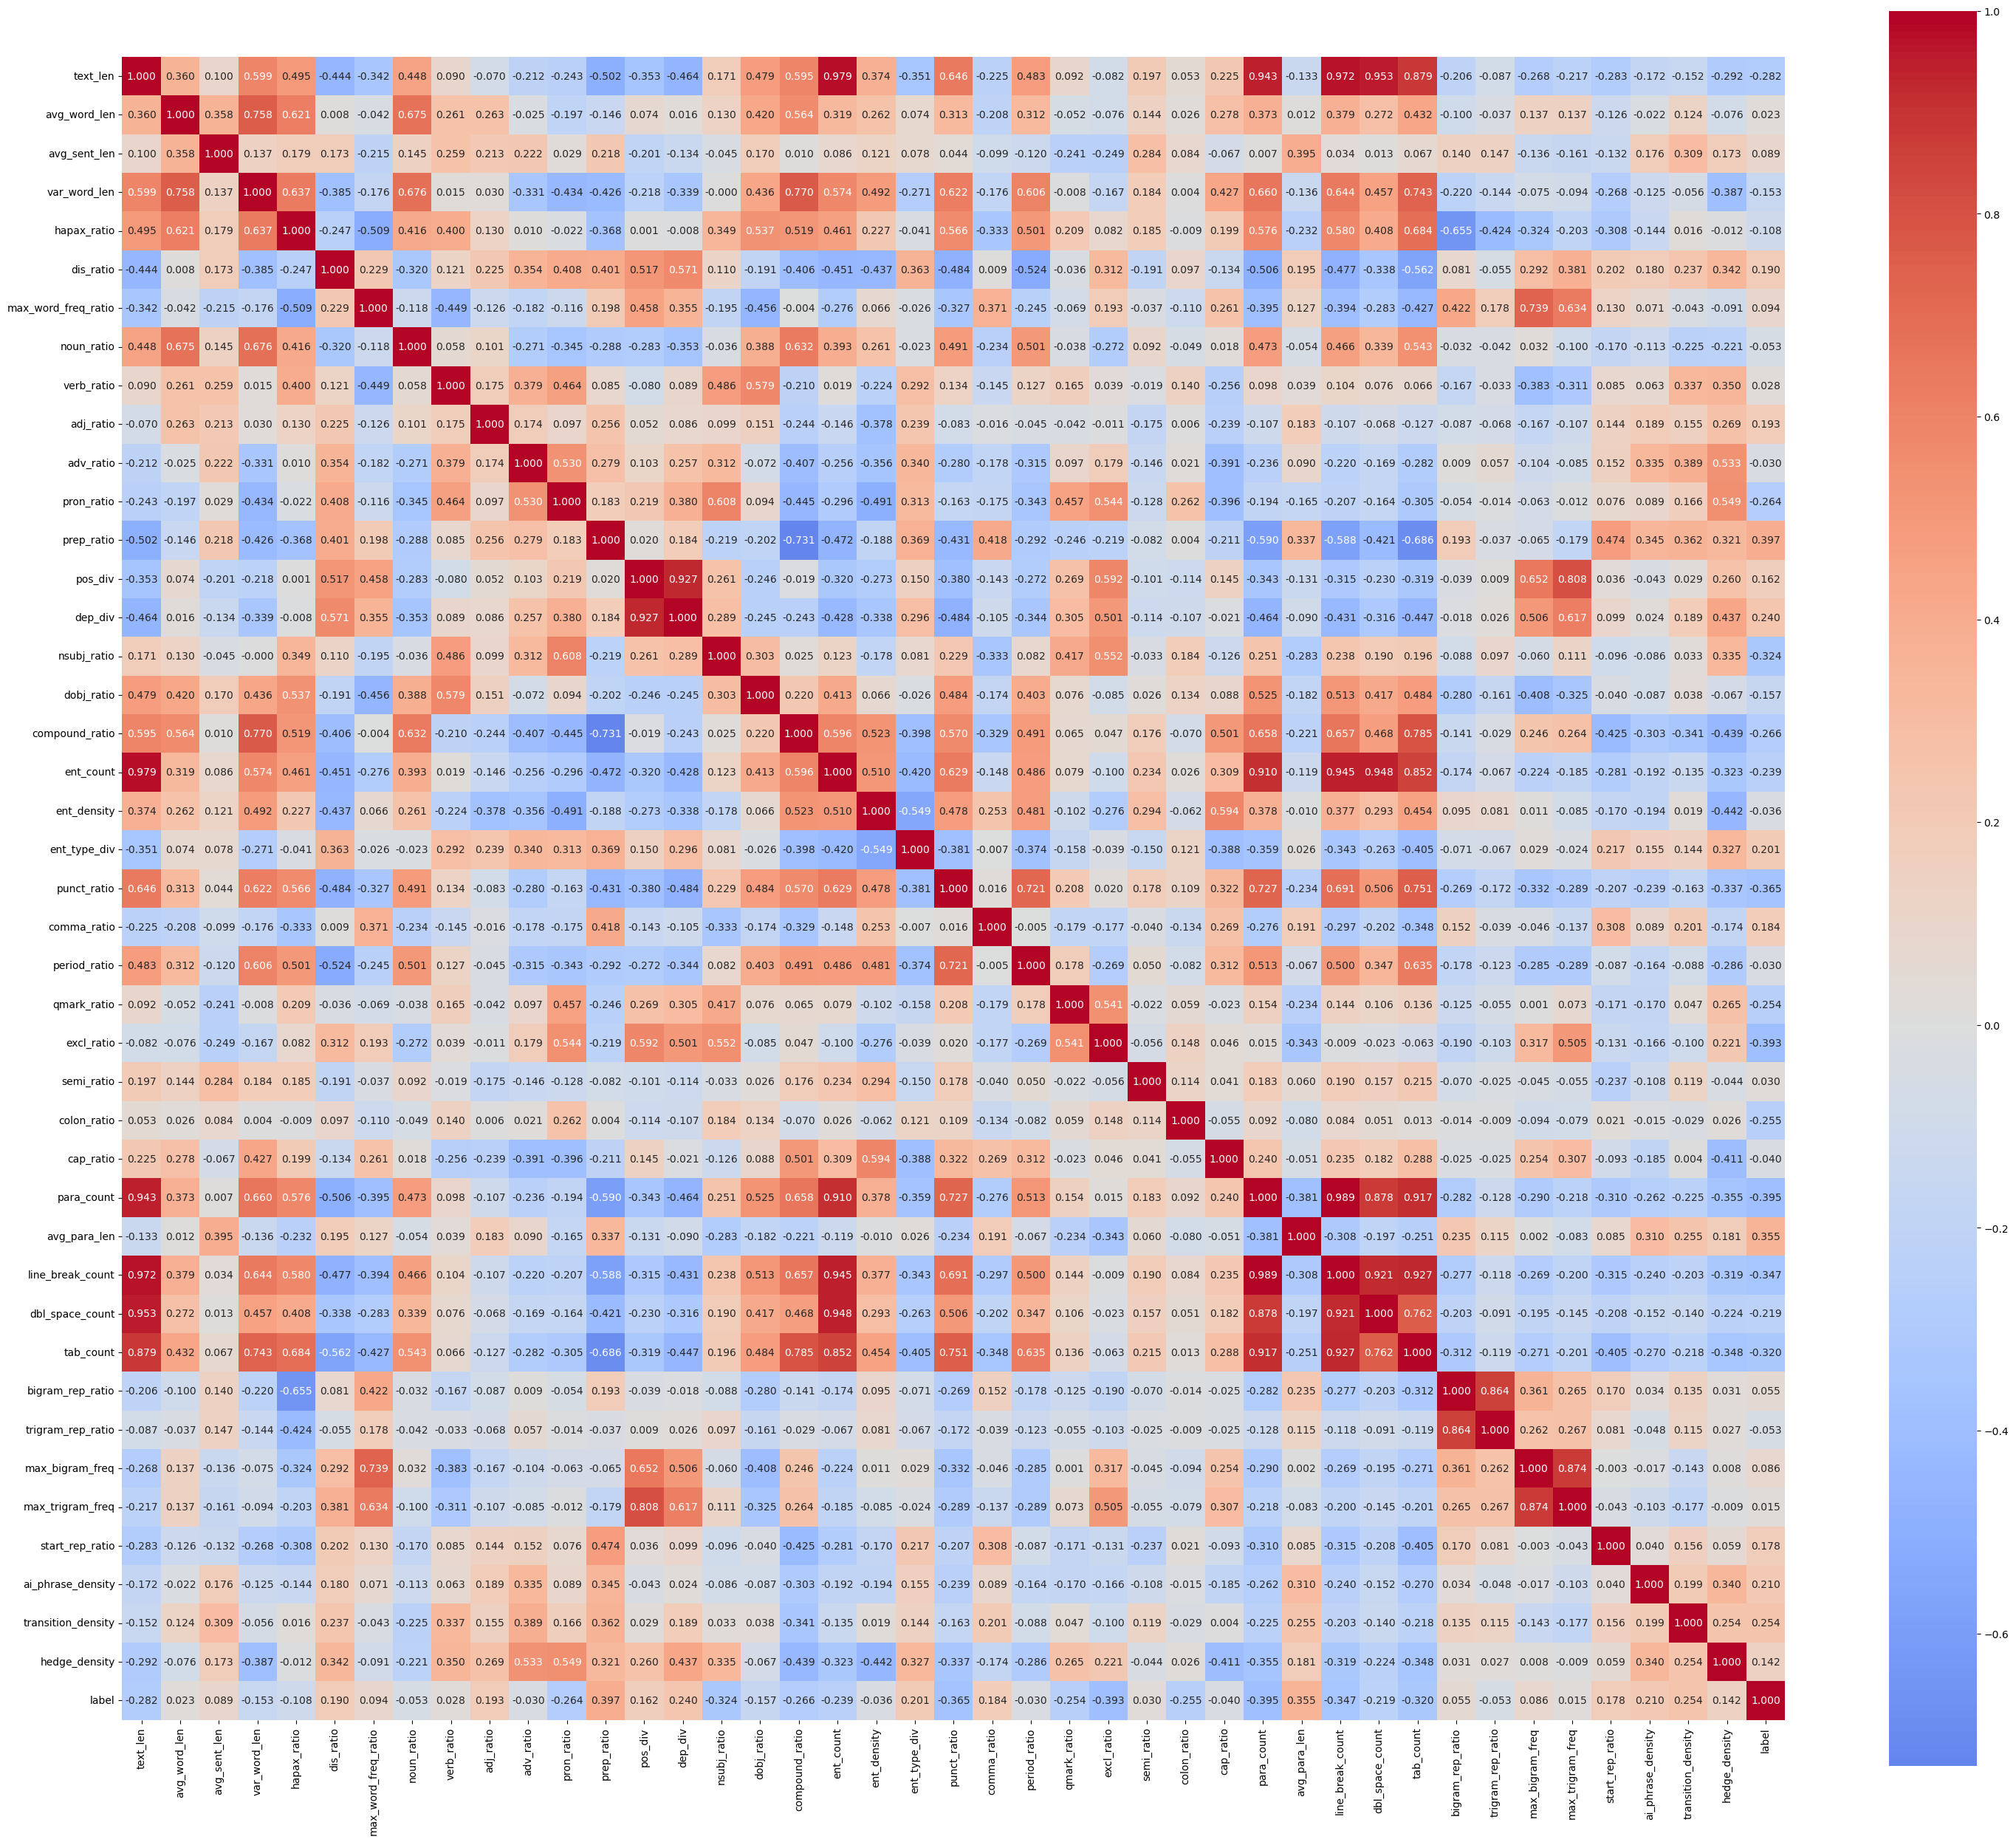

In [21]:
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            fmt='.3f',
            cbar_kws={"shrink": .8})

plt.tight_layout()
plt.show()